#### Considering additional chemicals beyond the centroids 

#### Reworking to consider whether there is a sweet spot for the number of additional substances

Created by: Grace Patlewicz<br>
Last modified: 10 May 2024<br>
Change: Additional background, Rework given the inventory changed in April 2024.

In response to the question of whether there is a defined number of candidates to select which will cover a specific structural diversity. This notebook tries some exploratory work to uncover a means of using the MaxMin approach to derive a ranked list of diverse chemicals on a per terminal category basis from which a plot of number of diverse picks vs structural coverage % captured could be constructed.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os
from scipy.spatial.distance import pdist, squareform
import sys

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'

In [3]:
LIB = TOP+'src/models/'
if not LIB in sys.path: 
    sys.path.insert(0,LIB)

In [4]:
from model_functions import *

In [5]:
df = pd.read_excel(interim_dir+'final_universe_wMaxMin_100524.xlsx',  index_col = [0])

In [6]:
df.head()

,dtxsid,DSSTox_QC-Level,Substance_Name,Substance_CASRN,Substance_Type,Substance_Note,smiles,Structure_InChI,Structure_InChIKey,Structure_Formula,...,lvl_cluster_d,lvl3_centroid,lvl3_centroid2,lvl3_analogues,lvl3_Dist,final_centroid,final_dist,group,group_str,MaxMin_picks
0,IROQAHVXXUQBOS-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,CCCN(CCNC(=O)c1ccc(Cc2ccc(C(O)=O)cc2)cc1)S(=O)...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,IROQAHVXXUQBOS-UHFFFAOYSA-N,0.000000,"('Aromatic PFASs', 'gte7', nan, nan)","('Aromatic PFASs', 'gte7', nan, nan)",1
1,DTXSID90897582,DSSTox_High,4-(Perfluorononyl)oxybenzenesulfonate sodium,91998-13-9,Single Compound,NaN,[Na+].[O-]S(=O)(=O)C1=CC=C(OC(F)(F)C(F)(F)C(F)...,"InChI=1S/C15H5F19O4S.Na/c16-7(17,8(18,19)10(22...",WEKFOCTWTWPVEG-UHFFFAOYSA-M,C15H4F19NaO4S,...,NaN,NaN,NaN,NaN,NaN,IROQAHVXXUQBOS-UHFFFAOYSA-N,0.788889,"('Aromatic PFASs', 'gte7', nan, nan)","('Aromatic PFASs', 'gte7', nan, nan)",0
2,DTXSID90896257,Public_Low,(2S)-2-{Bis[4-(heptadecafluorooctyl)phenyl][(t...,914391-37-0,Single Compound,NaN,CC[Si](CC)(CC)OC([C@@H]1CCCN1)(C1=CC=C(C=C1)C(...,"InChI=1S/C39H31F34NOSi/c1-4-76(5-2,6-3)75-23(2...",PARYPNCCAOUHML-QFIPXVFZSA-N,C39H31F34NOSi,...,NaN,NaN,NaN,NaN,NaN,IROQAHVXXUQBOS-UHFFFAOYSA-N,0.814815,"('Aromatic PFASs', 'gte7', nan, nan)","('Aromatic PFASs', 'gte7', nan, nan)",0
3,DTXSID90896196,Public_Low,"2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,9-Heptadecaflu...",157584-47-9,Single Compound,NaN,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,"InChI=1S/C21H10F17NO/c22-14(23,13(40)39(11-7-3...",IDJHICNQDCLWAB-UHFFFAOYSA-N,C21H10F17NO,...,NaN,NaN,NaN,NaN,NaN,IROQAHVXXUQBOS-UHFFFAOYSA-N,0.788889,"('Aromatic PFASs', 'gte7', nan, nan)","('Aromatic PFASs', 'gte7', nan, nan)",0
4,DTXSID90896095,Public_Low,"3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,10-Heptadeca...",113823-56-6,Single Compound,NaN,CC1=CC=C(C=C1)S(=O)(=O)OCCC(F)(F)C(F)(F)C(F)(F...,"InChI=1S/C17H11F17O3S/c1-8-2-4-9(5-3-8)38(35,3...",WGCSEECKLMOBLT-UHFFFAOYSA-N,C17H11F17O3S,...,NaN,NaN,NaN,NaN,NaN,IROQAHVXXUQBOS-UHFFFAOYSA-N,0.791667,"('Aromatic PFASs', 'gte7', nan, nan)","('Aromatic PFASs', 'gte7', nan, nan)",0


In [7]:
df.columns

Index(['dtxsid', 'DSSTox_QC-Level', 'Substance_Name', 'Substance_CASRN',
       'Substance_Type', 'Substance_Note', 'smiles', 'Structure_InChI',
       'Structure_InChIKey', 'Structure_Formula',
       ...
       'lvl_cluster_d', 'lvl3_centroid', 'lvl3_centroid2', 'lvl3_analogues',
       'lvl3_Dist', 'final_centroid', 'final_dist', 'group', 'group_str',
       'MaxMin_picks'],
      dtype='object', length=195)

In [8]:
df.final_centroid.nunique()

128

In [9]:
cats = df['group_str'].unique().tolist()

In [10]:
def content_max(df,  k = None):
    content = {}
    tdf = df[df['group_str'] == k]
    content['t_dict'] = {k:Chem.MolFromSmiles(v) for k,v in zip(tdf['dtxsid'], tdf['smiles'])}
    content['fp_dict'] = [AllChem.GetMorganFingerprintAsBitVect(i, 3, 1024) for i in content['t_dict'].values()]
    content['nfp_dict'] = len(content['fp_dict'])
    content['t_index'] = {k:v for k,v in enumerate(content['t_dict'].keys())} 
    content['dm'] = pd.DataFrame(squareform(pdist(pd.DataFrame(np.array(content['fp_dict']), index = content['t_dict'].keys()), 'jaccard')), index = content['t_dict'].keys(), columns = content['t_dict'].keys())
    content['k'] = k
    
    return content

In [11]:
lte_summaries = []
for k in cats:
    try:
        lte_summaries.append(content_max(df, k))
    except Exception as error:
        print(k)

In [12]:
from rdkit.SimDivFilters import MaxMinPicker

In [13]:
def picker_func(fps, n1, start_with  = 1, n2 = 3, label = None, fps_index = None):
    picker_dict = {}
    mmp = MaxMinPicker()
    picker_dict['label'] = label
    picker_dict['indices'] = mmp.LazyBitVectorPick(fps,n1, start_with+n2, [0])
    picker_dict['diverse_chems'] = [fps_index[x] for x in picker_dict['indices']]
    return picker_dict

In [14]:
picker_lst = []
for i in range(len(lte_summaries)):
    if lte_summaries[i]['nfp_dict'] > 5:
        picker_lst.append(picker_func(lte_summaries[i]['fp_dict'], n1 =lte_summaries[i]['nfp_dict'], n2 = lte_summaries[i]['nfp_dict']-1, label = lte_summaries[i]['k'], fps_index = lte_summaries[i]['t_index'],))


In [15]:
def representive(df, lst):
    temps = []
    for n in range(1,len(lst)):
        a = lst[:n]
        b = np.mean(np.min(df.loc[a], axis = 0))
        temps.append([n,b])
    new_df = pd.concat([pd.DataFrame(temps), np.cumsum(pd.DataFrame(temps)[1])], axis = 1)
    new_df.columns = ['#', 'min', 'cummin']
    new_df['norm_min'] = new_df['cummin']/np.sum(new_df['min'])
    return new_df

In [16]:
index_pick = {k: picker_lst[k]['label'] for k in range(len(picker_lst))}
rev_index_picks = {v:k for k,v in index_pick.items()}

In [17]:
def summary_exp(i = 0):
    summary = {}
    k = lte_summaries[i]['k']
    x = rev_index_picks[k]
    summary['label'] = lte_summaries[i]['k']
    summary['representative'] = representive(lte_summaries[i]['dm'],picker_lst[x]['diverse_chems'])
    summary['chk'] = summary['label'], x
    return summary

In [18]:
representive(lte_summaries[0]['dm'], picker_lst[0]['diverse_chems'])

,#,min,cummin,norm_min
0,1,0.713949,0.713949,0.007231
1,2,0.698777,1.412726,0.014308
2,3,0.689015,2.101742,0.021287
3,4,0.676452,2.778193,0.028138
4,5,0.659103,3.437297,0.034814
...,...,...,...,...
578,579,0.000000,98.733865,1.000000
579,580,0.000000,98.733865,1.000000
580,581,0.000000,98.733865,1.000000
581,582,0.000000,98.733865,1.000000


In [19]:
check_lst = []
for e in range(len(lte_summaries)):
    try:
        a = summary_exp(i=e)
    except Exception as error:
        print(e)
    finally:
        check_lst.append(a)

23
24
25
63
66
121
122


In [20]:
def how_many(df, threshold = 0.8):
    return df.loc[np.where(df['norm_min'] >threshold)[0][0], '#']

In [21]:
def threshold_3(df, threshold = 3):
    return df.loc[np.where(df['#'] == threshold)[0][0], 'norm_min']

In [22]:
number_chems = {}
for e in range(len(check_lst)):
    a = how_many(check_lst[e]['representative'], threshold = 0.8)
    b = check_lst[e]['label']
    c = np.round(threshold_3(check_lst[e]['representative'], threshold = 3)*100,2)
    d = check_lst[e]['representative'].shape[0]+1
    number_chems[b] =[a,c,d]

In [23]:
df2 = pd.concat([pd.DataFrame(list(number_chems.items())), pd.DataFrame(list(number_chems.items()))[1].apply(pd.Series)], axis=1)
df2.columns = ['terminal_category', 'temp', 'ideal#', '%diversity', 'category_size']
df2.drop(['temp'], axis = 1, inplace =True)

In [46]:
df2.sort_values('%diversity', ascending = False).to_csv(interim_dir+'category_diversity_unconstrained_051024.csv')

In [25]:
df2.sort_values('%diversity', ascending = False)

,terminal_category,ideal#,%diversity,category_size
23,"('Other PFASs, cyclic', 'gte7', 4.0, nan)",3.0,84.03,6.0
83,"('Polyfluoroalkyl acids, cyclic', 'lt7', 3.0, ...",3.0,83.67,11.0
113,"('unclassified', 'lt7', 1.0, 1.0)",4.0,67.35,8.0
25,"('Other PFASs, cyclic', 'lt7', 1.0, 2.0)",4.0,67.14,9.0
62,"('PFAAs, cyclic', 'lt7', 3.0, 2.0)",5.0,64.87,9.0
...,...,...,...,...
97,"('others', 'lt7', 3.0, 1.0)",162.0,2.43,350.0
32,"('PASF-based substances', 'lt7', nan, nan)",237.0,2.17,697.0
0,"('Aromatic PFASs', 'gte7', nan, nan)",214.0,2.13,584.0
3,"('Aromatic PFASs', 'lt7', 2.0, 2.0)",268.0,1.48,592.0


In [47]:
df2[df2['%diversity']>=50].sort_values('%diversity', ascending = False).shape

(15, 4)

In [49]:
df2[df2['%diversity']>=50].sort_values('%diversity', ascending = False).to_csv(interim_dir+'diversity50_unconstrained_100524.csv')

In [27]:
df2.describe()

,ideal#,%diversity,category_size
count,121.000000,121.000000,121.000000
mean,48.942149,20.122314,128.140496
std,64.987088,19.165447,169.356050
min,3.000000,0.800000,6.000000
25%,13.000000,7.880000,37.000000
50%,30.000000,12.590000,72.000000
75%,51.000000,27.320000,161.000000
max,528.000000,84.030000,1238.000000


In [28]:
check_lst[0]

{'label': "('Aromatic PFASs', 'gte7', nan, nan)",
 'representative':        #       min     cummin  norm_min
 0      1  0.713949   0.713949  0.007231
 1      2  0.698777   1.412726  0.014308
 2      3  0.689015   2.101742  0.021287
 3      4  0.676452   2.778193  0.028138
 4      5  0.659103   3.437297  0.034814
 ..   ...       ...        ...       ...
 578  579  0.000000  98.733865  1.000000
 579  580  0.000000  98.733865  1.000000
 580  581  0.000000  98.733865  1.000000
 581  582  0.000000  98.733865  1.000000
 582  583  0.000000  98.733865  1.000000
 
 [583 rows x 4 columns],
 'chk': ("('Aromatic PFASs', 'gte7', nan, nan)", 0)}

In [29]:
def plot_rep(df, label = None):
    fig, ax = plt.subplots(figsize = (10,9))
    ax.set_xlabel('Number of chemicals')
    ax.set_ylabel('Cumulative minimum distance')
    ax.plot(df['#'],  df['norm_min'], linestyle = 'none', marker = '.', label = label)
    ax.legend(bbox_to_anchor=(1, 1))
    return fig, ax

(<Figure size 1000x900 with 1 Axes>,
 <Axes: xlabel='Number of chemicals', ylabel='Cumulative minimum distance'>)

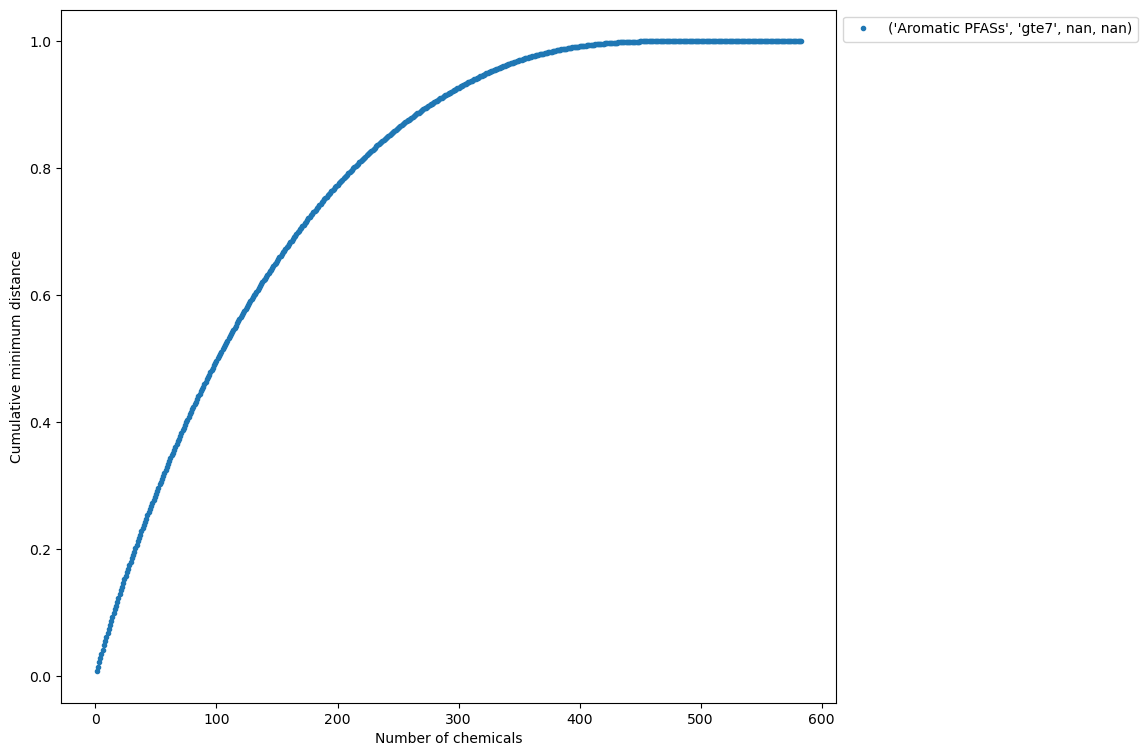

In [30]:
plot_rep(check_lst[0]['representative'], label = check_lst[0]['label'])

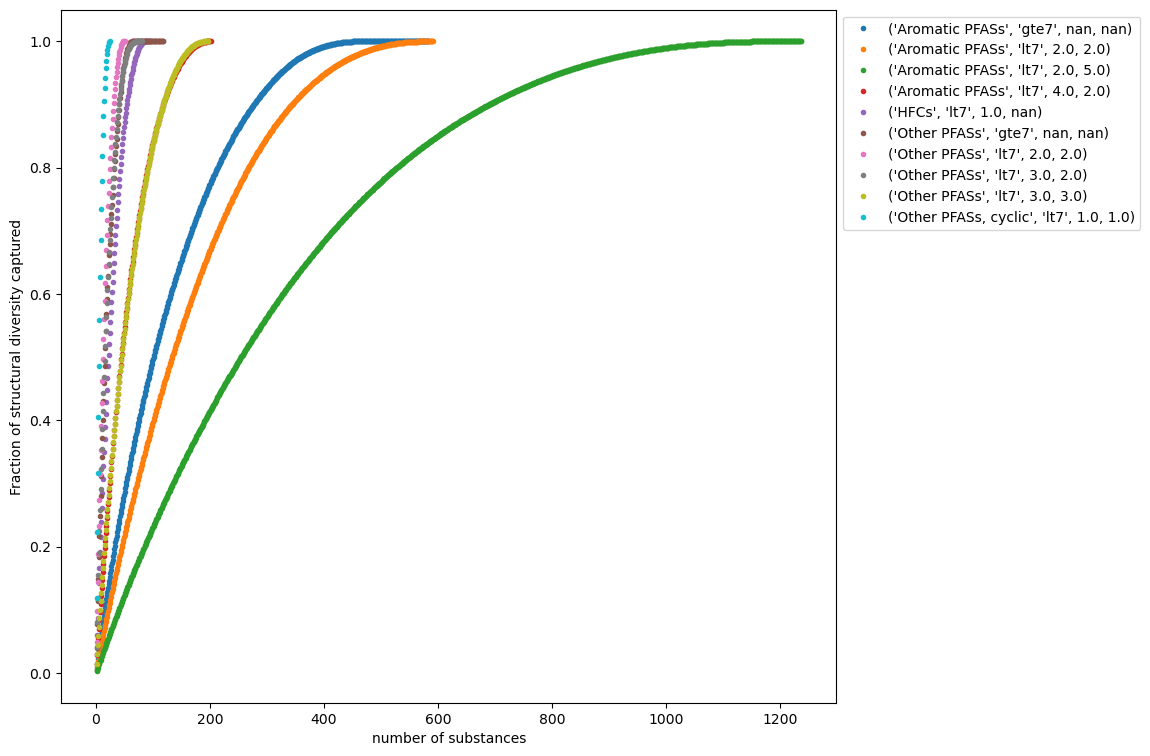

In [31]:
fig, ax = plt.subplots(figsize = (10,9))
for i in range(len(check_lst))[0:30:3]:
    ax.set_ylabel('Fraction of structural diversity captured')
    ax.set_xlabel('number of substances')
    #ax.set_title('ECDFs of within Category-Subcategory combinations')
    ax.plot(check_lst[i]['representative']['#'],check_lst[i]['representative']['norm_min'], marker = '.', linestyle = 'none', label = check_lst[i]['label'])
    ax.legend(bbox_to_anchor=(1, 1))
    #ax.annotate(" ", xy = (0.65,0.8), xytext = (0.5, 0.8), arrowprops = dict(arrowstyle = '->', lw = 2, color = 'black'))
fig.savefig(figures_dir+'Figure1_structural_diversity_100524.png', dpi = 300, bbox_inches='tight')

In [32]:

#check_lst[0]['representative']['norm_min']

In [33]:
mydf = []
for i in range(0,len(check_lst)):
    a = check_lst[i]['representative']
    a['category'] = check_lst[i]['label']
    mydf.append(a)


In [34]:
newdf = pd.concat(mydf)

In [35]:
newdf['pct_norm_min'] = round(100*newdf['norm_min'],2)

In [36]:
new_df = pd.pivot_table(newdf, index = 'category', values = 'pct_norm_min', columns = '#')

In [37]:
new_df2 = new_df.copy()
new_df2 = new_df2.replace(np.nan,100)
new_df2

#,1,2,3,4,5,6,7,8,9,10,...,1228,1229,1230,1231,1232,1233,1234,1235,1236,1237
category,,,,,,,,,,,,,,,,,,,,,
"('Aromatic PFASs', 'gte7', nan, nan)",0.72,1.43,2.13,2.81,3.48,4.14,4.80,5.44,6.09,6.72,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
"('Aromatic PFASs', 'lt7', 1.0, nan)",1.13,2.26,3.37,4.46,5.54,6.60,7.66,8.71,9.75,10.78,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
"('Aromatic PFASs', 'lt7', 2.0, 1.0)",1.17,2.34,3.50,4.65,5.79,6.92,8.05,9.16,10.27,11.37,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
"('Aromatic PFASs', 'lt7', 2.0, 2.0)",0.50,0.99,1.48,1.96,2.44,2.92,3.39,3.86,4.33,4.80,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
"('Aromatic PFASs', 'lt7', 2.0, 3.0)",3.83,7.36,10.65,13.87,16.84,19.63,22.37,24.98,27.52,29.92,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"('unclassified', 'lt7', 2.0, 3.0)",17.04,31.69,44.81,56.47,66.71,75.56,83.01,89.07,93.75,97.06,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
"('unclassified', 'lt7', 3.0, 1.0)",10.20,19.83,28.91,37.35,45.28,52.36,58.91,64.98,70.56,75.55,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
"('unclassified', 'lt7', 3.0, 2.0)",21.85,40.62,55.75,67.78,77.77,85.78,91.89,96.17,98.73,100.00,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


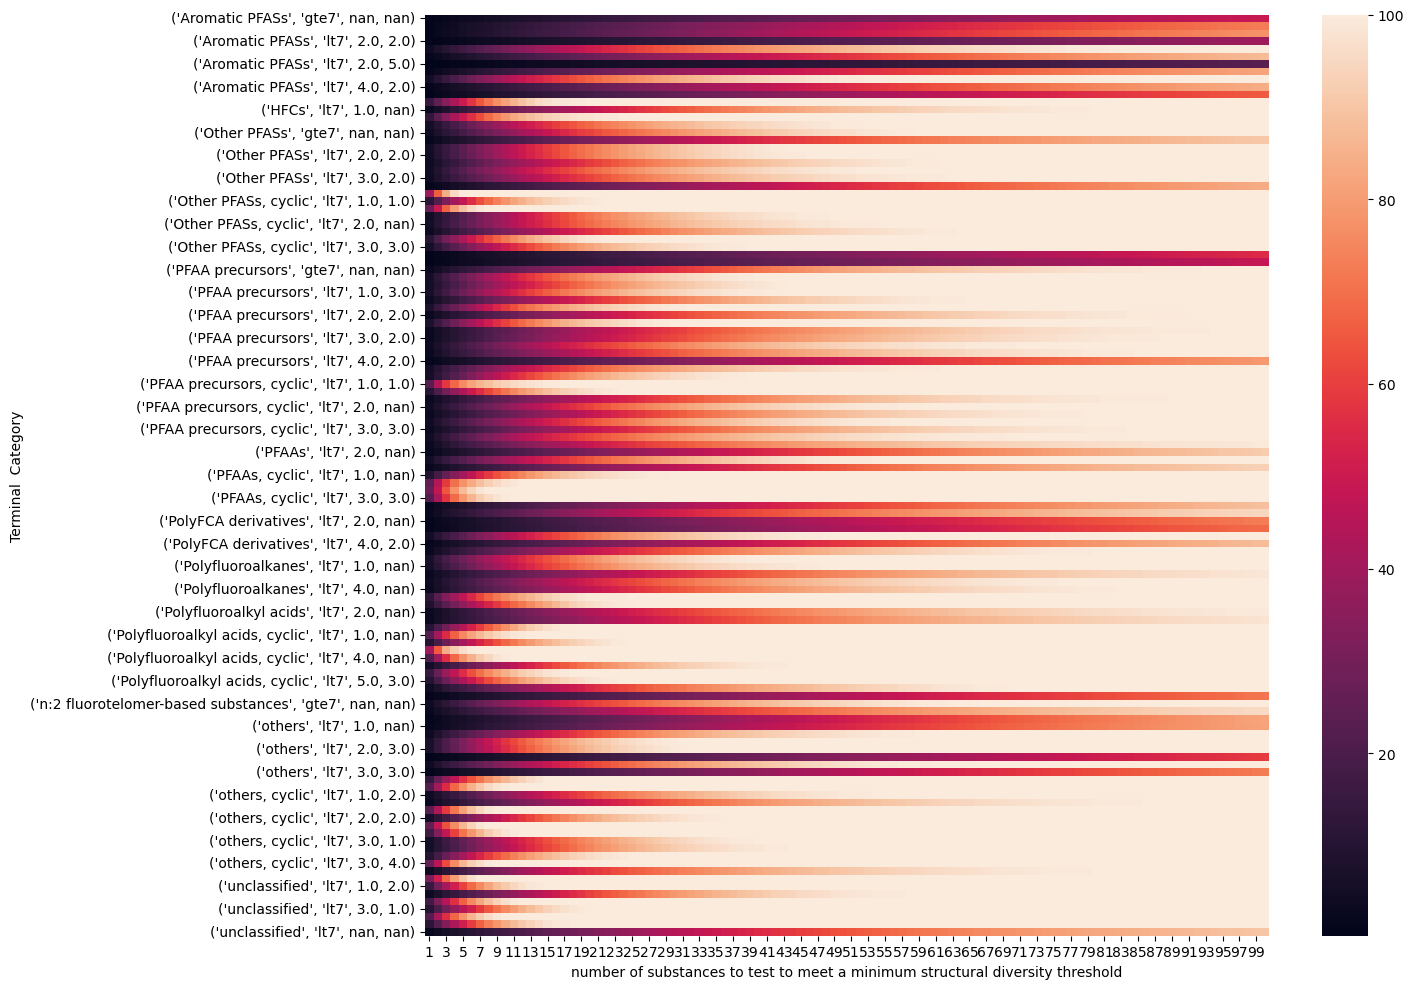

In [38]:
plt.figure(figsize = (15,10))
sns.heatmap(new_df2.iloc[:,:100])
plt.xlabel('number of substances to test to meet a minimum structural diversity threshold')
plt.ylabel('Terminal  Category')
plt.tight_layout()
plt.savefig(figures_dir+'structural_diversity_hm_100524.png', dpi = 300)

In [39]:
number_chems2 = []


for e in range(len(check_lst)):
    for i in np.arange(0.1,1,0.1):
        a = how_many(check_lst[e]['representative'], threshold = i)
        #print(a)
        b = check_lst[e]['label']
        number_chems2.append([a,b,i])

In [40]:
df3 = pd.DataFrame(number_chems2, columns = ['#ideal', 'terminal_category', 'threshold'])
df3

,#ideal,terminal_category,threshold
0,16,"('Aromatic PFASs', 'gte7', nan, nan)",0.1
1,33,"('Aromatic PFASs', 'gte7', nan, nan)",0.2
2,53,"('Aromatic PFASs', 'gte7', nan, nan)",0.3
3,76,"('Aromatic PFASs', 'gte7', nan, nan)",0.4
4,101,"('Aromatic PFASs', 'gte7', nan, nan)",0.5
...,...,...,...
1147,36,"('unclassified', 'lt7', nan, nan)",0.5
1148,46,"('unclassified', 'lt7', nan, nan)",0.6
1149,58,"('unclassified', 'lt7', nan, nan)",0.7
1150,75,"('unclassified', 'lt7', nan, nan)",0.8


In [41]:
df4 = pd.pivot_table(df3, index = 'terminal_category', values = '#ideal', columns = 'threshold')

In [42]:
df4.loc['other'] = list(np.repeat(5,9))

In [43]:
df5 = df4.sum(axis = 0).reset_index()

df5.columns = ['threshold', '#']

In [44]:
df5['threshold'] = (df5.threshold * 100)

In [50]:
df5

,threshold,#
0,10.0,509
1,20.0,1014
2,30.0,1575
3,40.0,2197
4,50.0,2904
5,60.0,3724
6,70.0,4702
7,80.0,5927
8,90.0,7653


<Figure size 1000x900 with 0 Axes>

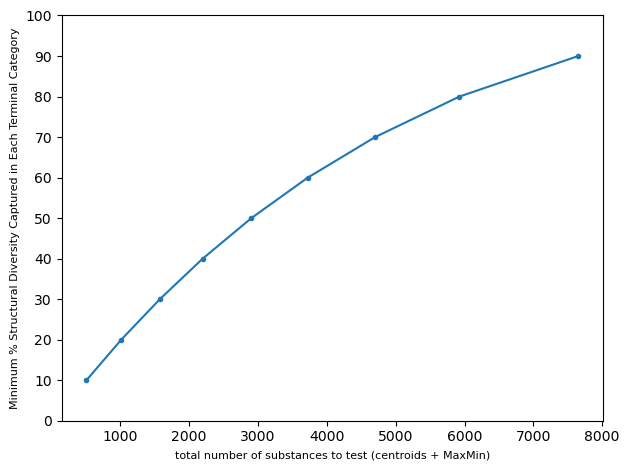

In [45]:
plt.figure(figsize = (10,9))
df5.plot(y = 'threshold', x = '#', marker = '.',legend = False)
#plt.ylim(0,150)
plt.ylim(0,100)
plt.yticks(np.arange(0, 100+10, 10.0))
plt.ylabel('Minimum % Structural Diversity Captured in Each Terminal Category', fontsize = 8)
plt.xlabel('total number of substances to test (centroids + MaxMin)', fontsize = 8)
plt.tight_layout()
plt.savefig(figures_dir+'Terminal_categorisation_unconstrained_landscape_100524.png', dpi = 300)